
# How to check all possible target binding sites against off-target binding sites in whole transcriptome
We have a target mRNA that we want to bind with RNA binding proteins. To design these pumby proteins we need to select binding sites on our target mRNA which are very unique, i.e. ideally dont occure elsewhere the transcriptome.  Or more general: We have a target sequence and we want to find a subsequence of specified length which is as specific to this target as possible i.e. has the least interactions with dataset of reference sequences. 

**This notebook is focused on testing and building up step by step the basic algorithm using random sequences.** To see the algorithm applied to real sequences see the "main" notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from time import time

In [2]:

@njit
def sc_jit(seq, ref):
    '''A fast sequence comparison of a short query sequence (seq) against a larger reference (ref).
    Returns the number of matches for every position the sort sequence could bind to the larger one. Consideres only full overlap binding, i.e. no overhangs '''

    n = len(ref) - len(seq) + 1
    if n<1: print("sc_jit: wrong argument order")
    cv = np.zeros(n, dtype=np.int8) 
    for i in range(n):
        WEIGHT = 0
        for j in range(len(seq)):
            if ref[i + j] == seq[j]:
                WEIGHT += 1
        cv[i] = WEIGHT
    return cv
    
def random_seq(size):
    return ''.join(np.array(["A", "C", "G", "T"])[np.random.randint(low = 0, high = 4, size = size)])

sc_jit(random_seq(10), random_seq(10));    # call it once so that numba compiles it

# Search off-target binding-sites on single transcript 
= global sequence comparison of query with a reference sequence
- as we are searching for binding sites in the transcriptome, we'd ideally find as few as possible to avoid unwanted side-effects.
- As the binding sites are usually shorter then the persistence length of the polymers, a global sequence alignment search should suffice (we dont need BLAST)

In [3]:
query = pd.Series({"SEQ_NAME": "rand_candidate",     "SEQUENCE": random_seq(size = 12)})       # the query sequence i.e. a candidate binding sequence for the target 
ref   = pd.Series({"SEQ_NAME": "rand_transcript_#0", "SEQUENCE": random_seq(size = 10**3)})    # The reference to check against, i.e. a transcript from the transcriptome in this example

{'mismatch_eq_0': np.int64(0),
 'mismatch_eq_1': np.int64(0),
 'mismatch_eq_2': np.int64(0),
 'boltzmann factor': np.float64(0.025126824849572658)}

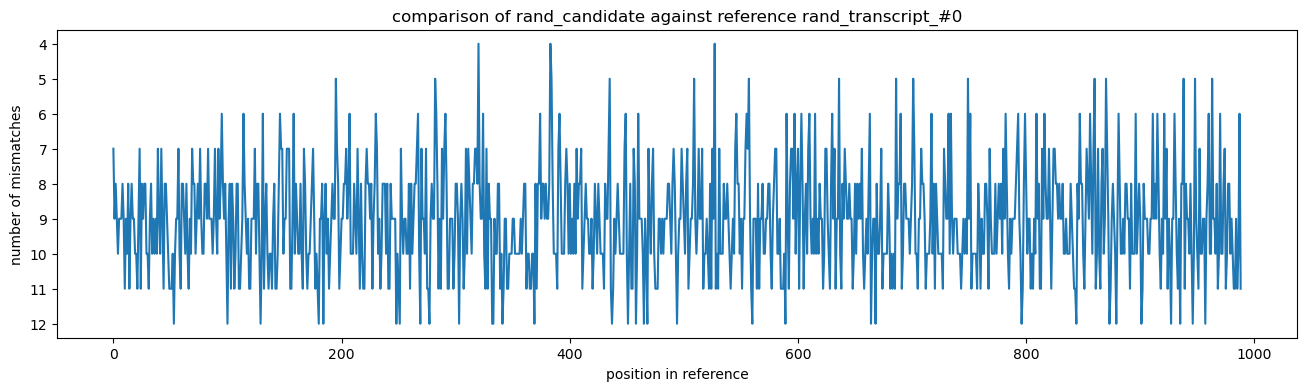

In [4]:
mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode("utf-8"), ref.SEQUENCE.encode("utf-8")) # number of mismatches per position

sc_results = {}                                              # summarize the possible binding sites of the query sequence against one reference sequence i.e. a transcript from the transcriptome
sc_results["mismatch_eq_0"] = (mm==0).sum()                  # number of idential matches
sc_results["mismatch_eq_1"] = (mm==1).sum()                  # number of matches with 1 mismatch
sc_results["mismatch_eq_2"] = (mm==2).sum()                  # number of matches with 2 mistmatches
sc_results["boltzmann factor"] = np.sum(np.exp(-1.5*mm))     # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
        
plt.figure(figsize=(16, 4))
plt.plot(mm)
plt.gca().invert_yaxis()
plt.ylabel("number of mismatches")
plt.xlabel(f"position in reference")
plt.title(f"comparison of {query.SEQ_NAME} against reference {ref.SEQ_NAME}")
sc_results

# Search for off-target binding-sites in a dataset of transcripts
= compare a query to a dataset of reference sequences

In [20]:
binding_site_len = 11  # length of the binding sites (8-12 for pumby)
plot = True
use_weights = True


# generate input sequences
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i}", "SEQUENCE": random_seq(size = 10**3), "WEIGHT": np.random.poisson(5)/5} for i in range(10000)])  # The reference to check against, i.e. a transcript from the transcriptome in this example
target_sequence   = pd.Series(    {"SEQ_NAME": "random_target",           "SEQUENCE": random_seq(size = 800),   "WEIGHT": 1})                                           # The sequence from which we want ot find the best/unique binding site

# generate dataset of all possible binding sequences
query_dataset = pd.DataFrame([{"SEQ_NAME": target_sequence.SEQ_NAME + f"_{k}:{k+binding_site_len}", "SEQUENCE":target_sequence.SEQUENCE[k:k+binding_site_len],  "WEIGHT": target_sequence.WEIGHT} for k in range(len(target_sequence.SEQUENCE)-binding_site_len)] )
query = query_dataset.sample().iloc[0]  # pick a random binding site candidate for this test
query

SEQ_NAME    random_target_582:593
SEQUENCE              AAAGTATATGA
WEIGHT                          1
Name: 582, dtype: object

In [21]:
###  Search for binding sites of query sequence in reference dataset  
detailed_search_results = pd.DataFrame()                     # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome
joined_DF = pd.concat([pd.DataFrame([target_sequence]), reference_dataset], axis = 0)

if use_weights:  # check if the inputs are sufficient
    if "WEIGHT" in joined_DF.columns:
        nan = pd.isna(joined_DF.WEIGHT)
        if  nan.any(): print(f"{dsr_nan.sum()} entries with nan WEIGHT")
        #print("Note: weighted values are simply  >> number of binding sites * WEIGHT <<  i.e. depends on type of WEIGHTs provided ")
    else: 
        print("No WEIGHT column found, switching 'use_weights = False'")

for i, ref in joined_DF.iterrows():                # iterate over all reference sequences. and the target itself as control 
    
    mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode("utf-8"), ref.SEQUENCE.encode("utf-8")) # number of mismatches per position # utf8 encoding of strings to integers speeds up the comparison for some reason
    sc_row = {"SEQ_NAME": ref.SEQ_NAME} # summarize the possible binding sites of the query sequence against one reference sequence (here a transcript)
    if use_weights: sc_row["WEIGHT"] = ref.WEIGHT
    sc_row["identical match"] = (mm==0).sum()                # number of idential matches
    sc_row["1nt mismatch"]    = (mm==1).sum()                # number of sites with 1 mismatch
    sc_row["2nt mismatch"]    = (mm==2).sum()                # number of sites with 2 mistmatches
    sc_row["boltzmann factor"] = np.sum(np.exp(-1.5*mm))     # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
    
    detailed_search_results = pd.concat([detailed_search_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this reference (here transcript) to the dataset

detailed_search_results.sort_values("boltzmann factor")

,SEQ_NAME,WEIGHT,identical match,1nt mismatch,2nt mismatch,boltzmann factor
3472,random_transcript_#3471,0.8,0,0,0,0.027025
7985,random_transcript_#7984,0.6,0,0,0,0.027755
8765,random_transcript_#8764,1.8,0,0,0,0.028138
9119,random_transcript_#9118,1.4,0,0,0,0.028261
2147,random_transcript_#2146,0.4,0,0,0,0.028261
...,...,...,...,...,...,...
5608,random_transcript_#5607,1.2,0,1,1,0.337655
3501,random_transcript_#3500,0.4,0,1,1,0.339991
4242,random_transcript_#4241,0.4,0,1,2,0.392666
2955,random_transcript_#2954,0.8,1,0,0,1.042456


In [22]:
def round(x, digits = 2):
    mag = -int(np.floor(np.log10(x))-digits+1)
    return np.round(x, mag).astype([int, float][int(mag > 0)])

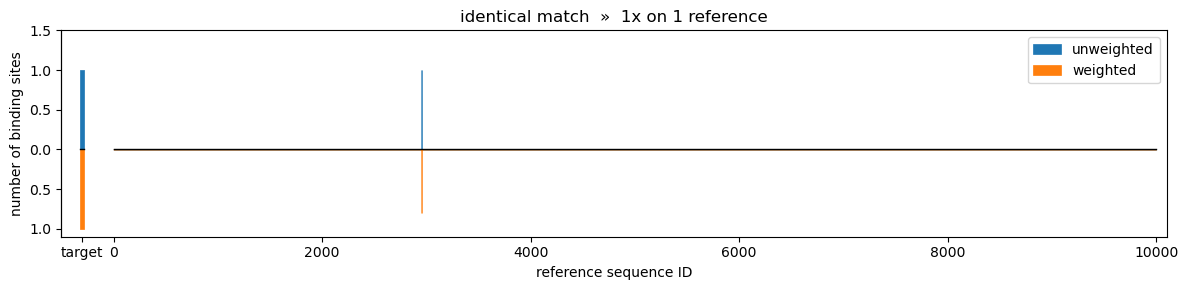

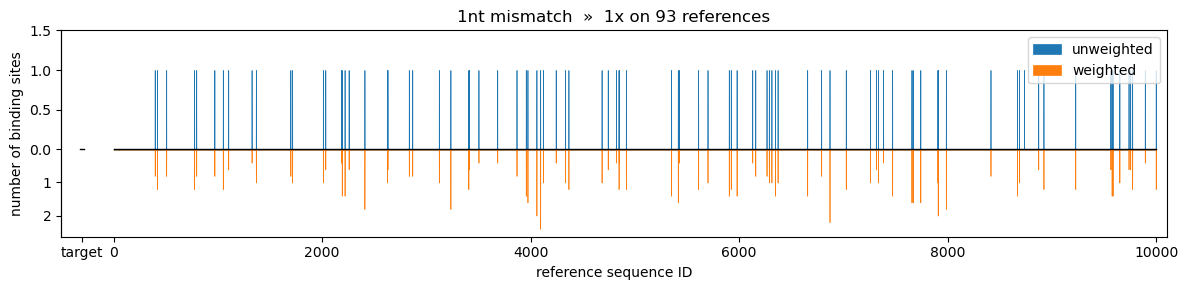

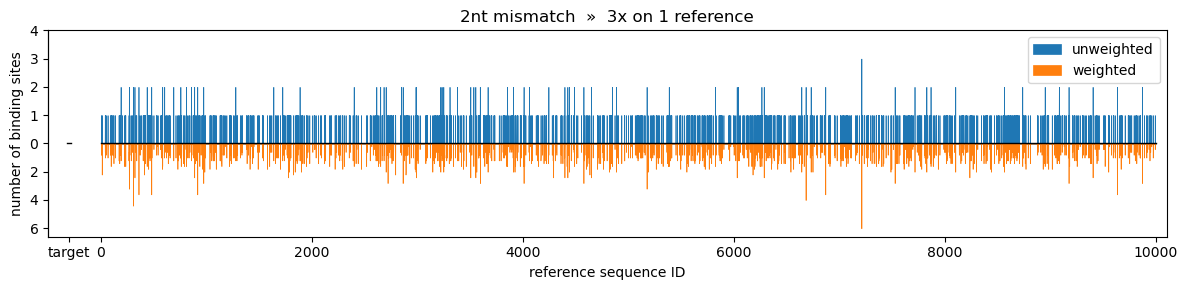

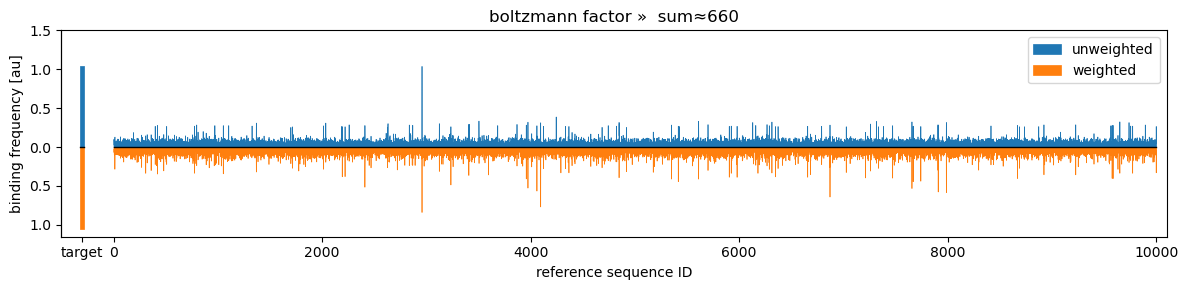

In [23]:

results_R = detailed_search_results.loc[~(detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME)]
results_Q = detailed_search_results.loc[  detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME]

for i, col in enumerate(detailed_search_results.drop(["SEQ_NAME", "WEIGHT"], axis = 1).columns): # iterate over all the metrics that should be summarized
    
    metric = results_R[col].values
    metriQ = results_Q[col].values[0]
    
    if use_weights:
        if detailed_search_results[col].max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).max() != 0:
            sy = detailed_search_results[col].max() / (detailed_search_results[col]*detailed_search_results.WEIGHT).max() # used for plotting
        else: sy = 1
        wetric =  results_R[col].values * results_R["WEIGHT"].values
        wetriQ = (results_Q[col].values * results_Q["WEIGHT"].values)[0]
    
    if plot:
        xmax = len(metric)
        fig, ax = plt.subplots(1, 1, figsize = (12, 3))
        ax.plot([0, xmax], [0, 0], zorder = 10, color = "black", lw = 1)
        ax.plot([-.032*xmax, -.028*xmax], [0, 0], zorder = 10, color = "black", lw = 1)
        ax.fill_between(np.arange(xmax), metric, metric*0, color = "tab:blue", ec = "tab:blue", lw = .5, label = "unweighted")
        ax.fill_between([-.032*xmax, -.028*xmax], [metriQ,metriQ], [0,0], color = "tab:blue", ec = "tab:blue", lw = .5)

        if use_weights:
            ax.fill_between(np.arange(xmax), -wetric*sy, wetric*0, color = "tab:orange", ec = "tab:orange", lw = .5, label = "weighted")
            ax.fill_between([-.032*xmax, -.028*xmax], [-wetriQ*sy, -wetriQ*sy], [0,0], color = "tab:orange", ec = "tab:orange", lw = .5)
            ax.legend(loc = "upper right")

        insert = "" # for plotting labels
        if not "oltzman" in col:
            ax.set_ylabel("number of binding sites")
            if metric.max() > 0:  # i.e. if there are mismatches to plot.
                insert = f"  »  {metric.max()}x on {(metric == metric.max()).sum()} reference{'s'*int((metric == metric.max()).sum() != 1)}"
        else: # for boltzmann
            insert =  f" »  sum≈{round(metric.sum())}"
            ax.set_ylabel("binding frequency [au]")

        ax.set_title(col + insert)

        # x-axis formatting
        ax.set_xlabel("reference sequence ID")
        xt = plt.xticks()
        ax.set_xticks(np.concatenate([[-0.03*xmax], xt[0]]), labels = np.concatenate([["target"], xt[1]]))
        ax.set_xlim(-0.05*xmax, 1.01*xmax)
    
        # split y axis formatting
        yt = ax.get_yticks().copy()
        ax.set_yticks(yt[yt>=0])
        sec_y = ax.secondary_yaxis("left", functions = (lambda y: -y/sy, lambda y: -y*sy))
        plt.tight_layout() # need to be called before getting ytick values as this triggers matplotlib to calculate the layout and the ticks correctly.
        yt2 = sec_y.get_yticks()
        sec_y.set_yticks(yt2[yt2>0])
        
        plt.show()



In [24]:
### summarize comparison of query with reference dataset      
# now that we have a huge and detailed list of the sequence comparison with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
query_summary = {"SEQUENCE": query.SEQUENCE}    
for i, col in enumerate(detailed_search_results.drop(["SEQ_NAME", "WEIGHT"], axis = 1).columns): # iterate over all the metrics that should be summarized

    metric = results_R[col].values
    metriQ = results_Q[col].values[0]
    if use_weights:
        wetric =  results_R[col].values * results_R["WEIGHT"].values
        wetriQ = (results_Q[col].values * results_Q["WEIGHT"].values)[0]

    if "match" in col:
        insert = ""
        norm = 1
        norw = 1
    else:
        insert = " rel_2_target"
        norm = metriQ
        if use_weights: norw = wetriQ

    query_summary[ col + f" .max" + insert] = metric.max() / norm        # What was the highest number of off-target binding sites on a single reference i.e. transcript
    query_summary[ col + f" .sum" + insert] = metric.sum() / norw        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome

    if use_weights: 
        query_summary[ col + f" .W_max" + insert] = wetric.max() / norm  # What was the highest number of off-target binding sites on a single reference i.e. transcript
        query_summary[ col + f" .W_sum" + insert] = wetric.sum() / norw  # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome

query_summary

{'SEQUENCE': 'AAAGTATATGA',
 'identical match .max': np.float64(1.0),
 'identical match .sum': np.float64(1.0),
 'identical match .W_max': np.float64(0.8),
 'identical match .W_sum': np.float64(0.8),
 '1nt mismatch .max': np.float64(1.0),
 '1nt mismatch .sum': np.float64(93.0),
 '1nt mismatch .W_max': np.float64(2.4),
 '1nt mismatch .W_sum': np.float64(95.8),
 '2nt mismatch .max': np.float64(3.0),
 '2nt mismatch .sum': np.float64(1141.0),
 '2nt mismatch .W_max': np.float64(6.0),
 '2nt mismatch .W_sum': np.float64(1134.6),
 'boltzmann factor .max rel_2_target': np.float64(0.9950343057675206),
 'boltzmann factor .sum rel_2_target': np.float64(632.2857041031407),
 'boltzmann factor .W_max rel_2_target': np.float64(0.7960274446140165),
 'boltzmann factor .W_sum rel_2_target': np.float64(634.4975589119503)}

In [ ]:
def query_eval(query, reference_dataset, plot = False, use_weights=True):
    '''searches for (partial) matches between query sequence and reference dataset
    query: sequence to be found (pd.Series object)
    reference_dataset: pd.DataFrame of sequences to test against
    Both need at least a SEQ_NAME and a SEQUENCE column
    '''

    if type(query) == str:
        print("Warning, deprecated input type for query")
        query = pd.Series({"SEQ_NAME": "unnamed", "SEQUENCE": query})
    

    if use_weights:
        if "WEIGHT" in reference_dataset.columns and
        dsr_nan = pd.isna(detailed_search_results.WEIGHT)
        if  dsr_nan.any(): print(f"{dsr_nan.sum()} entries with nan WEIGHT")
        print("Note: weighted values are simply  >> number of binding sites * WEIGHT <<  i.e. depends on type of WEIGHTs provided ")


    #-------------------------------------------------#
    #  Search for binding sites in reference dataset  #
    #-------------------------------------------------#
     
    detailed_search_results = pd.DataFrame()                     # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome
    for i, ref in pd.concat([pd.DataFrame([target_sequence]), reference_dataset], axis = 0).iterrows():                # iterate over all reference sequences. and the target itself as control 
        
        mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode("utf-8"), ref.SEQUENCE.encode("utf-8")) # number of mismatches per position # utf8 encoding of strings to integers speeds up the comparison for some reason
        sc_row = {"SEQ_NAME": ref.SEQ_NAME, "WEIGHT":ref.WEIGHT} # summarize the possible binding sites of the query sequence against one reference sequence (here a transcript)
        sc_row["identical match"] = (mm==0).sum()                # number of idential matches
        sc_row["1nt mismatch"]    = (mm==1).sum()                # number of sites with 1 mismatch
        sc_row["2nt mismatch"]    = (mm==2).sum()                # number of sites with 2 mistmatches
        sc_row["boltzmann factor"] = np.sum(np.exp(-1.5*mm))     # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
        
        detailed_search_results = pd.concat([detailed_search_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this reference (here transcript) to the dataset

    #-------------------------------------------------------#
    # summarize interaction of query with reference dataset #       # now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
    #-------------------------------------------------------#
    
    query_summary = {"SEQUENCE": query.SEQUENCE, "SEQ_NAME": query.SEQ_NAME}
    if plot: fig, ax = plt.subplots(len(detailed_search_results.columns)-1, 2, figsize = (12, 8), gridspec_kw={'width_ratios': [1, 5]}, dpi = 180)
        
    for i, col in enumerate(detailed_search_results.drop("SEQ_NAME", axis = 1).columns): # iterate over all the metrics that should be summarized
        metric = detailed_search_results[col]
        e = 100
        query_summary[metric.name+f"_max"] = metric.max()  # What was the highest number of off-target binding sites on a single reference i.e. transcript
        query_summary[metric.name+f"_sum"] = metric.sum()  # What was the total number of off-target binding sites on the whole reference dataset i.e. transcriptome
        query_summary[metric.name+f"_score{e}"] = np.emath.logn(e, np.sum(np.pow(e, metric, dtype = np.double))).astype("float16")  # something inbetween max and sum, its a weighted sum where 100 references with one binding site are worth as much as one reference with two binding sites.  This penelizes outliers with a high number of binding sites on a single reference, while still containing the information of all other references as well. The e = 100 was chosen arbitrarily, there likly is a better way of weighting all this
        insert = "" # for plotting labels
        if plot:
            if metric.max() > 0 and i < 3: # i.e. if there are mismatches to plot. i==3 is pseudo prob and metric.max() <= 0 is no mismatches
                insert = f"  »  {metric.max()}x on {(metric == metric.max()).sum()} references"
                ax[i,0].hist(metric, log = True, range = (0.5, metric.max()+0.5), bins = np.ceil(metric.max()).astype(int), orientation='horizontal', rwidth = .8) # ignore the 0 mismatch per transcript bin, it might be to large
                if  metric.max() == 1: # with at most one mistmatch per reference, the histogram has only one bar
                    ax[i,0].set_yticks([1])
            elif i==3:
                ax[i,0].hist(metric, log = True, orientation='horizontal', rwidth = .8) # plot predicted binding pseudo probability (not normalized, i.e. arbitrary units)
            else:
                ax[i,0].set_yticks([0])
                
            ax[i,1].fill_between(np.arange(len(metric)), np.zeros(len(metric)), metric, ec = "tab:blue", fc = "tab:blue", lw = 0.2, alpha = 1)
            ax[i,0].set_xlabel("number of references")
            ax[i,0].set_ylabel("number of\n off-target binding sites")
            ax[i,1].set_xlabel("reference sequence ID")
            ax[i,1].set_xlim(-len(metric)*0.005, len(metric)*1.005)
            ax[i,1].set_title(metric.name + insert)
            ax[i,1].set_yticks([])
            plt.tight_layout()
    
    return query_summary


query_eval(query, reference_dataset, plot = plot)


# Now query all possible candidate sequences from the target (in parallel)


In [ ]:
target_sequence   = pd.Series(    {"SEQ_NAME": "random_target",           "SEQUENCE": random_seq(size = 80)})                             # The sequence from which we want ot find the best/unique binding site
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i}", "SEQUENCE": random_seq(size = 10**3)} for i in range(10000)])    # The references to check against, i.e. a transcript from the transcriptome in this example
binding_site_len = 12  # length of the binding sites (8-12 for pumby)
plot = True

# retrieve all possible binding sites of the target sequence
query_dataset = pd.DataFrame([{"SEQ_NAME": target_sequence.SEQ_NAME + f"_{k}:{k+binding_site_len}", "SEQUENCE":target_sequence.SEQUENCE[k:k+binding_site_len]} for k in range(len(target_sequence.SEQUENCE)-binding_site_len)] )
query_dataset  

,SEQ_NAME,SEQUENCE
0,random_target_0:12,CTTTTATTGCAA
1,random_target_1:13,TTTTATTGCAAC
2,random_target_2:14,TTTATTGCAACT
3,random_target_3:15,TTATTGCAACTA
4,random_target_4:16,TATTGCAACTAT
...,...,...
63,random_target_63:75,ACCTACTTTCTC
64,random_target_64:76,CCTACTTTCTCT
65,random_target_65:77,CTACTTTCTCTC
66,random_target_66:78,TACTTTCTCTCG


In [ ]:
#-------------------------------#
#  Parallel processing: joblib  #  
#-------------------------------#          # using joblib instead of multiprocessing becasue of windows compatibility
from joblib import Parallel, delayed
from tqdm import tqdm
scores = list(Parallel(n_jobs=-1)(delayed(query_eval)(query, reference_dataset) for row_ID, query in tqdm(query_dataset.iterrows(), total=len(query_dataset), ncols = 100)))

100%|███████████████████████████████████████████████████████████████| 68/68 [00:49<00:00,  1.38it/s]


# Visualize results

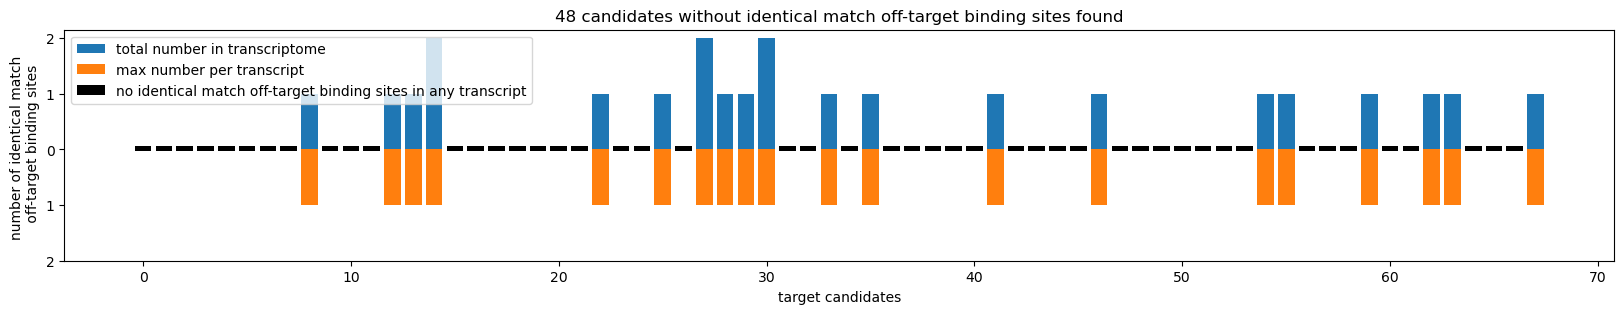

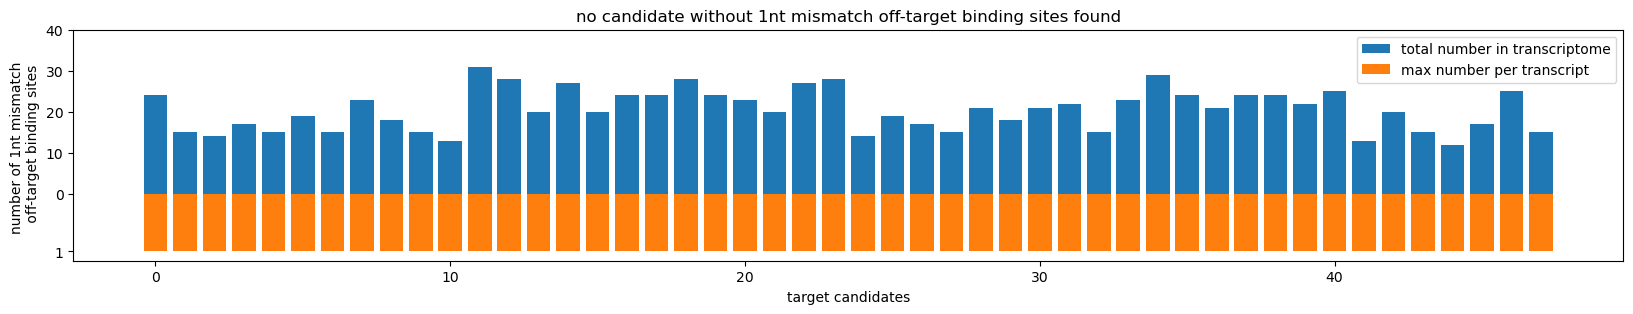

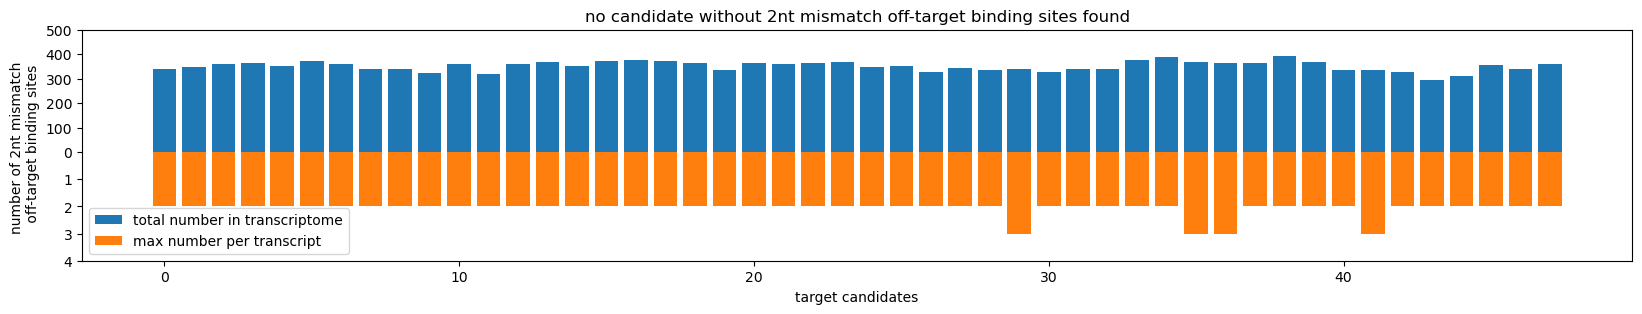

continue with 48 candidates


In [ ]:

## Visualize the the offtarget binding sites for every candidate sequence ## 
selections = []
df = pd.DataFrame(scores)
for col in ["identical match", "1nt mismatch", "2nt mismatch"]:
    col1 = col + f'_sum'
    col2 = col + f'_max'
    sel = df[df[col1]<0.5]
    selections.append(sel)
    
    plt.figure(figsize = (20, 3))
    sy = np.round(0.66 * df[col1].mean() / df[col2].mean(), 0).astype(int) # rescaling for the lower half of the plot, only visual
    plt.bar(df.index,  df[col1].values, label = "total number in transcriptome")
    plt.bar(df.index, -df[col2].values*sy,  label = "max number per transcript")
    if len(sel) > 0:
        plt.bar(sel.index, .04*df[col1].max(), bottom = -.02*df[col2].max()*sy, label = f"no {col} off-target binding sites in any transcript", color = "black")
    plt.xlabel("target candidates")
    plt.ylabel(f"number of {col} \n off-target binding sites");
    yl = plt.yticks()[0]
    yl[yl<0] /= sy
    yl = np.unique(yl.round().astype(int))
    yt = yl.copy()
    yt[yt<0] *= sy
    plt.yticks(yt, np.abs(yl))
    plt.legend();

    if len(sel) == 0:
        plt.title(f"no candidate without {col} off-target binding sites found")
        plt.show()

    else: 
        df = sel.reset_index(drop = True)  # select only those with fewest number of offtarget binding sites
        plt.title(f"{len(sel)} candidates without {col} off-target binding sites found")
    plt.show()
select = df.copy()
print(f"continue with {len(select)} candidates")

In [ ]:
select

/home/l3x/.miniforge3/envs/F1/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SEQUENCE,SEQ_NAME,identical match_max,identical match_sum,identical match_score100,1nt mismatch_max,1nt mismatch_sum,1nt mismatch_score100,2nt mismatch_max,2nt mismatch_sum,2nt mismatch_score100,boltzmann factor_max,boltzmann factor_sum,boltzmann factor_score100
0,CTTTTATTGCAA,random_target_0:12,0,0,2.0,1,24,2.046875,2,341,2.525391,0.925293,4424.0,2.451172
1,TTTTATTGCAAC,random_target_1:13,0,0,2.0,1,15,2.029297,2,349,2.507812,0.856934,4424.0,2.451172
2,TTTATTGCAACT,random_target_2:14,0,0,2.0,1,14,2.027344,2,361,2.509766,0.868652,4428.0,2.451172
3,TTATTGCAACTA,random_target_3:15,0,0,2.0,1,17,2.033203,2,365,2.373047,0.922852,4432.0,2.451172
4,TATTGCAACTAT,random_target_4:16,0,0,2.0,1,15,2.029297,2,352,2.507812,0.865723,4428.0,2.451172
5,ATTGCAACTATC,random_target_5:17,0,0,2.0,1,19,2.037109,2,374,2.548828,0.876953,4432.0,2.451172
6,TTGCAACTATCG,random_target_6:18,0,0,2.0,1,15,2.029297,2,361,2.546875,0.948242,4428.0,2.449219
7,TGCAACTATCGG,random_target_7:19,0,0,2.0,1,23,2.044922,2,339,2.431641,0.933105,4432.0,2.451172
8,CAACTATCGGAG,random_target_9:21,0,0,2.0,1,18,2.035156,2,341,2.484375,0.877441,4428.0,2.449219
9,AACTATCGGAGG,random_target_10:22,0,0,2.0,1,15,2.029297,2,325,2.501953,0.911621,4428.0,2.449219


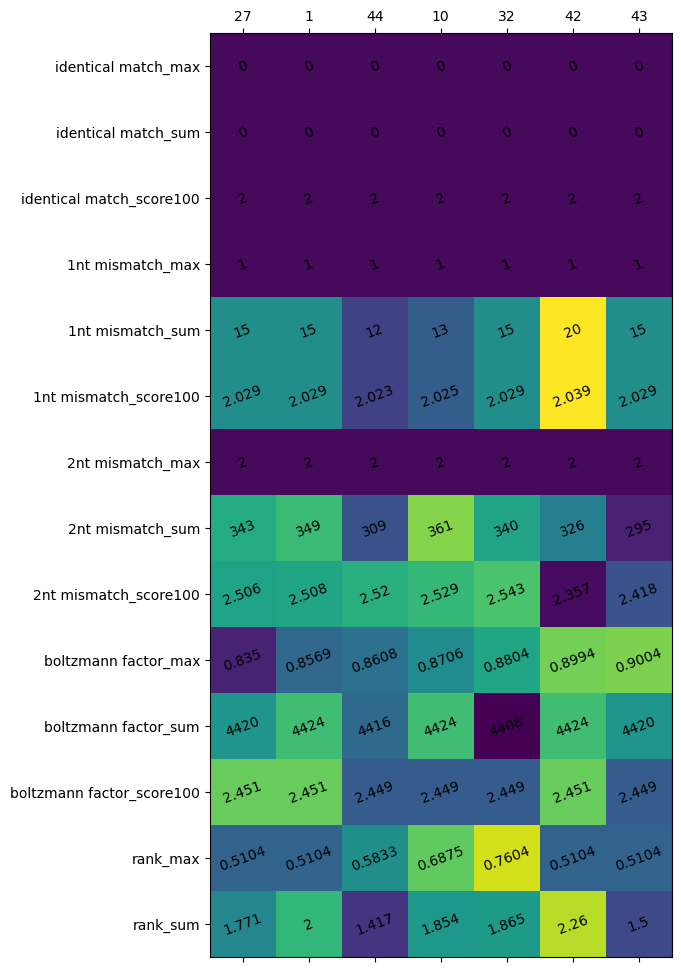


----------------------------------------------------------------------------------------------------
SEQUENCE                            TGCGCGGCTCGT
SEQ_NAME                     random_target_39:51
identical match_max                            0
identical match_sum                            0
identical match_score100                     2.0
1nt mismatch_max                               1
1nt mismatch_sum                              15
1nt mismatch_score100                   2.029297
2nt mismatch_max                               2
2nt mismatch_sum                             343
2nt mismatch_score100                   2.505859
boltzmann factor_max                    0.834961
boltzmann factor_sum                      4420.0
boltzmann factor_score100               2.451172
rank_max                                0.510417
rank_sum                                1.770833
Name: 27, dtype: object
Warning, deprecated input type for query


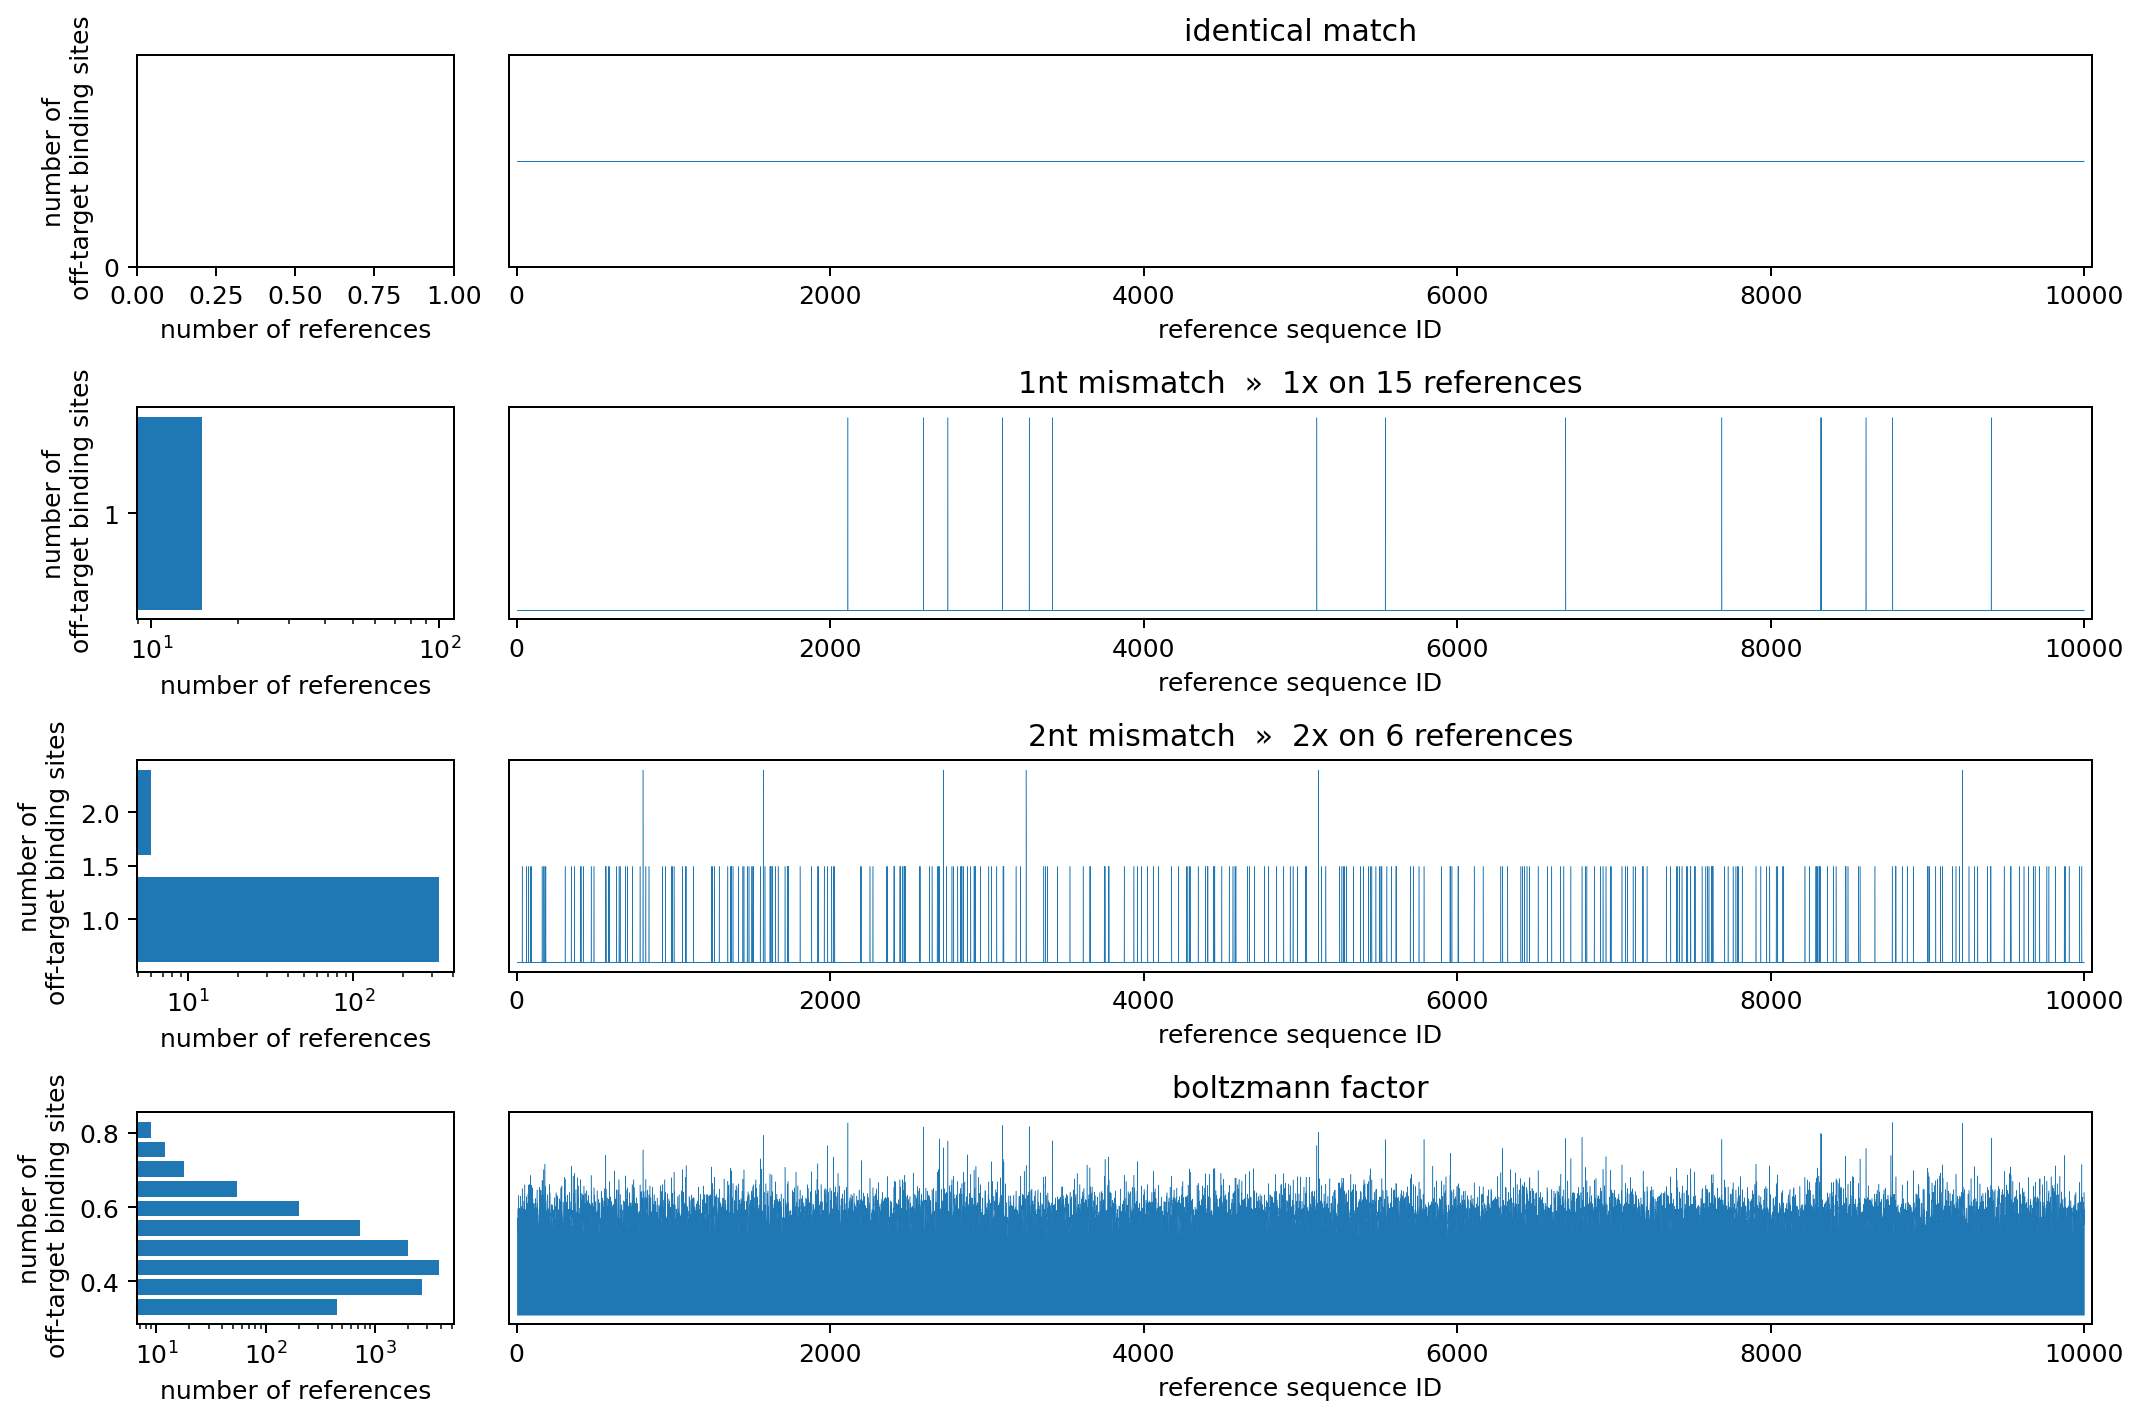


----------------------------------------------------------------------------------------------------
SEQUENCE                           TTTTATTGCAAC
SEQ_NAME                     random_target_1:13
identical match_max                           0
identical match_sum                           0
identical match_score100                    2.0
1nt mismatch_max                              1
1nt mismatch_sum                             15
1nt mismatch_score100                  2.029297
2nt mismatch_max                              2
2nt mismatch_sum                            349
2nt mismatch_score100                  2.507812
boltzmann factor_max                   0.856934
boltzmann factor_sum                     4424.0
boltzmann factor_score100              2.451172
rank_max                               0.510417
rank_sum                                    2.0
Name: 1, dtype: object
Warning, deprecated input type for query


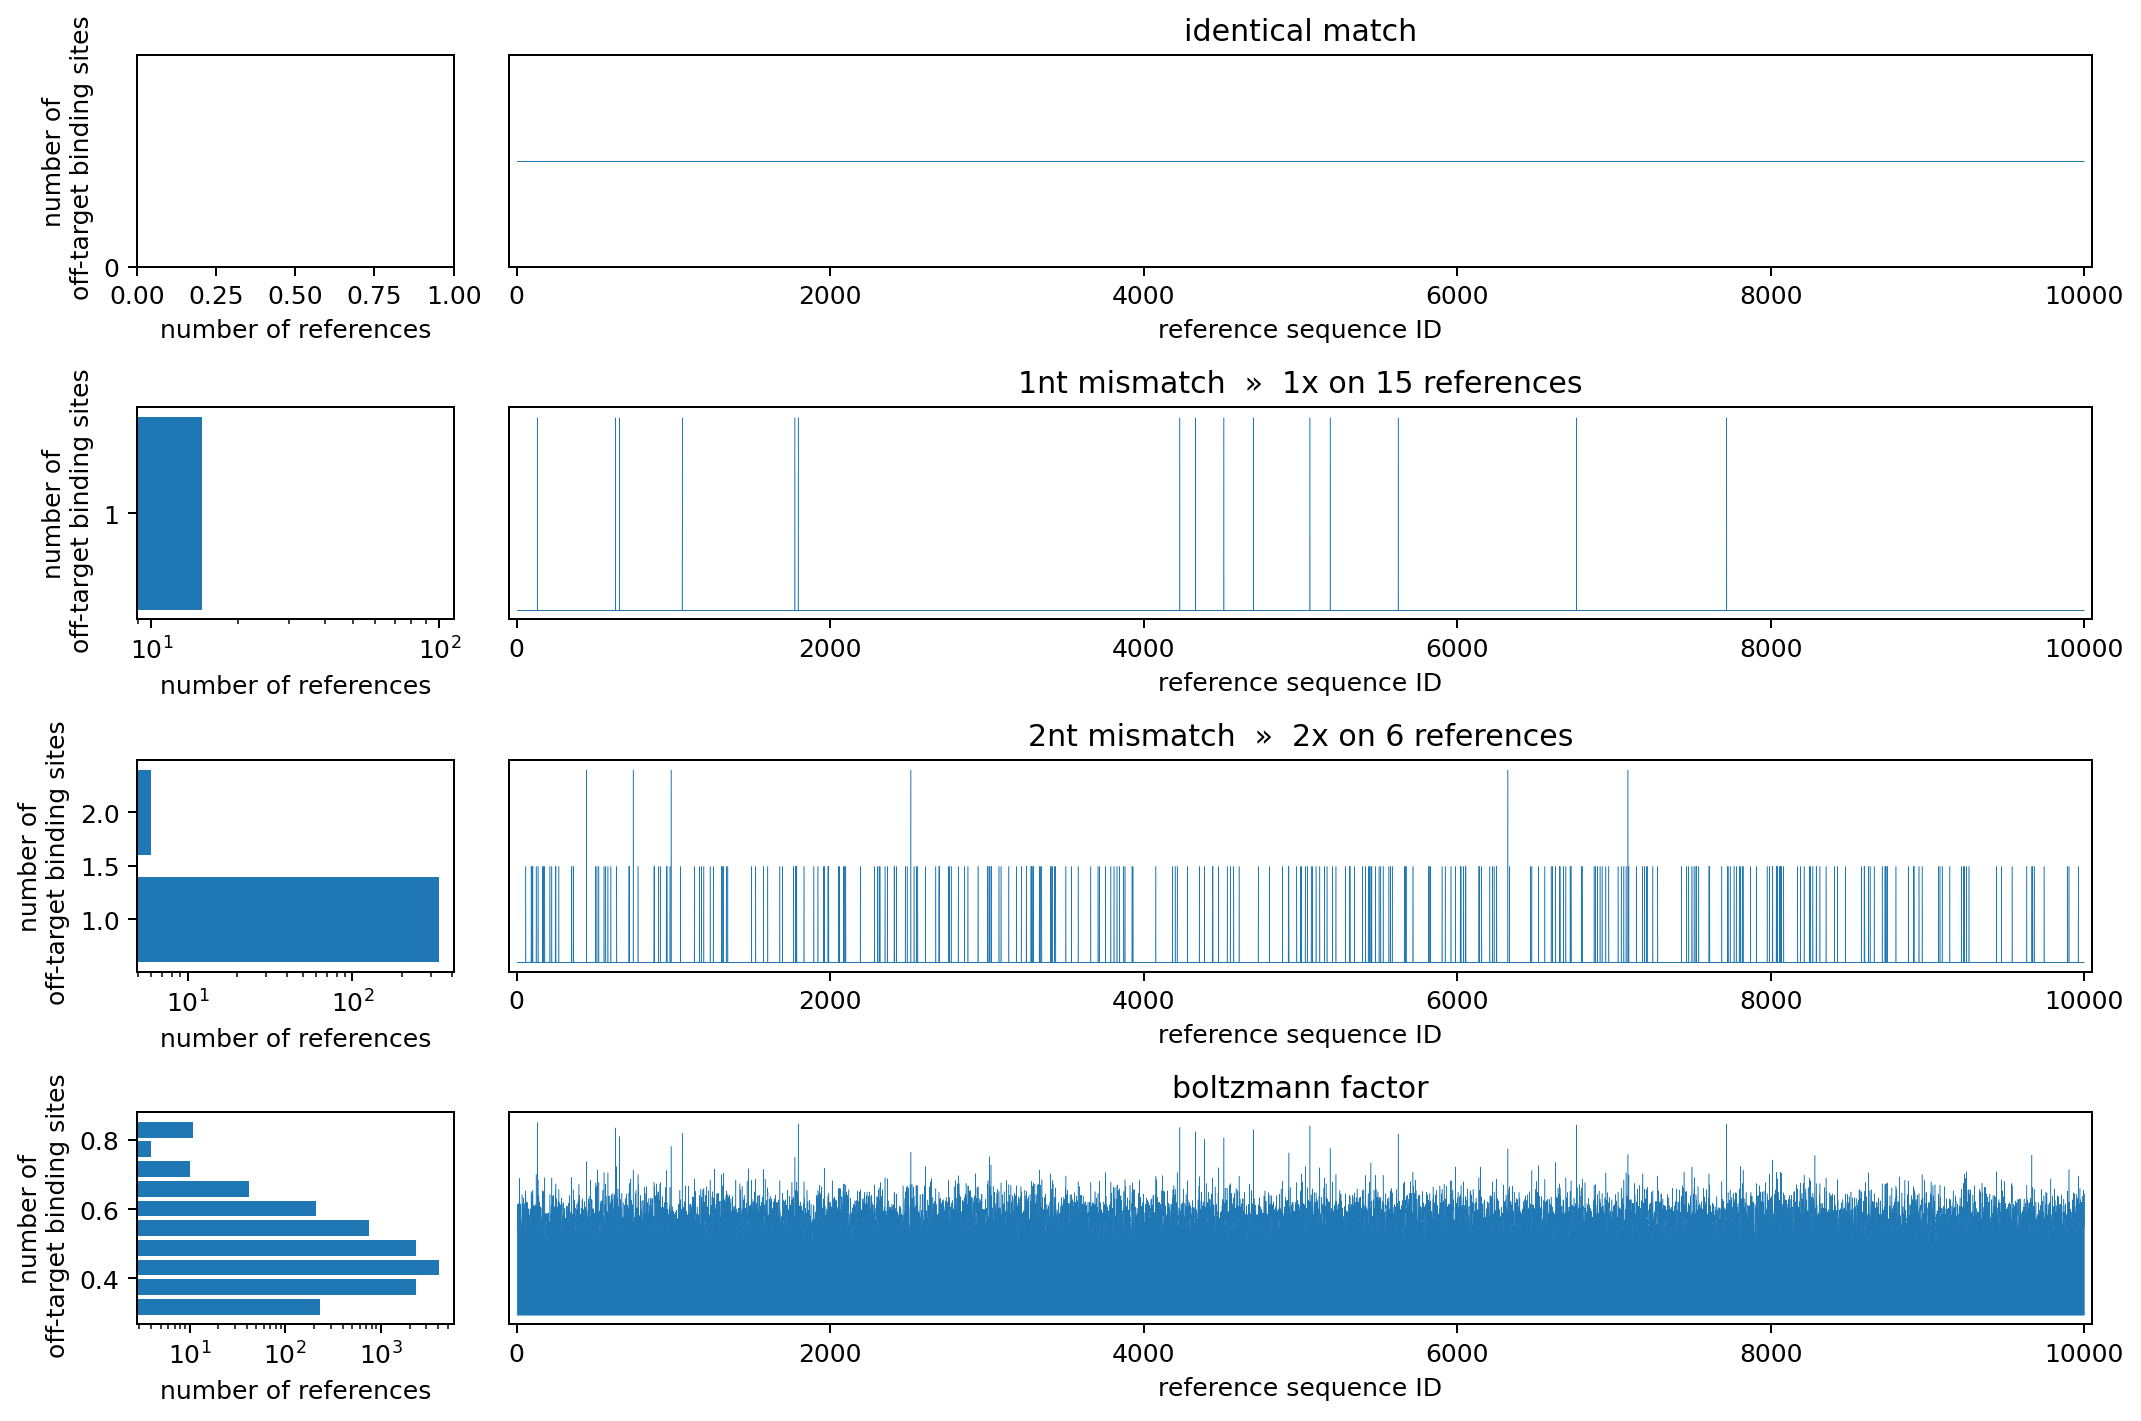


----------------------------------------------------------------------------------------------------
SEQUENCE                            AAACCTACTTTC
SEQ_NAME                     random_target_61:73
identical match_max                            0
identical match_sum                            0
identical match_score100                     2.0
1nt mismatch_max                               1
1nt mismatch_sum                              12
1nt mismatch_score100                   2.023438
2nt mismatch_max                               2
2nt mismatch_sum                             309
2nt mismatch_score100                   2.519531
boltzmann factor_max                     0.86084
boltzmann factor_sum                      4416.0
boltzmann factor_score100               2.449219
rank_max                                0.583333
rank_sum                                1.416667
Name: 44, dtype: object
Warning, deprecated input type for query


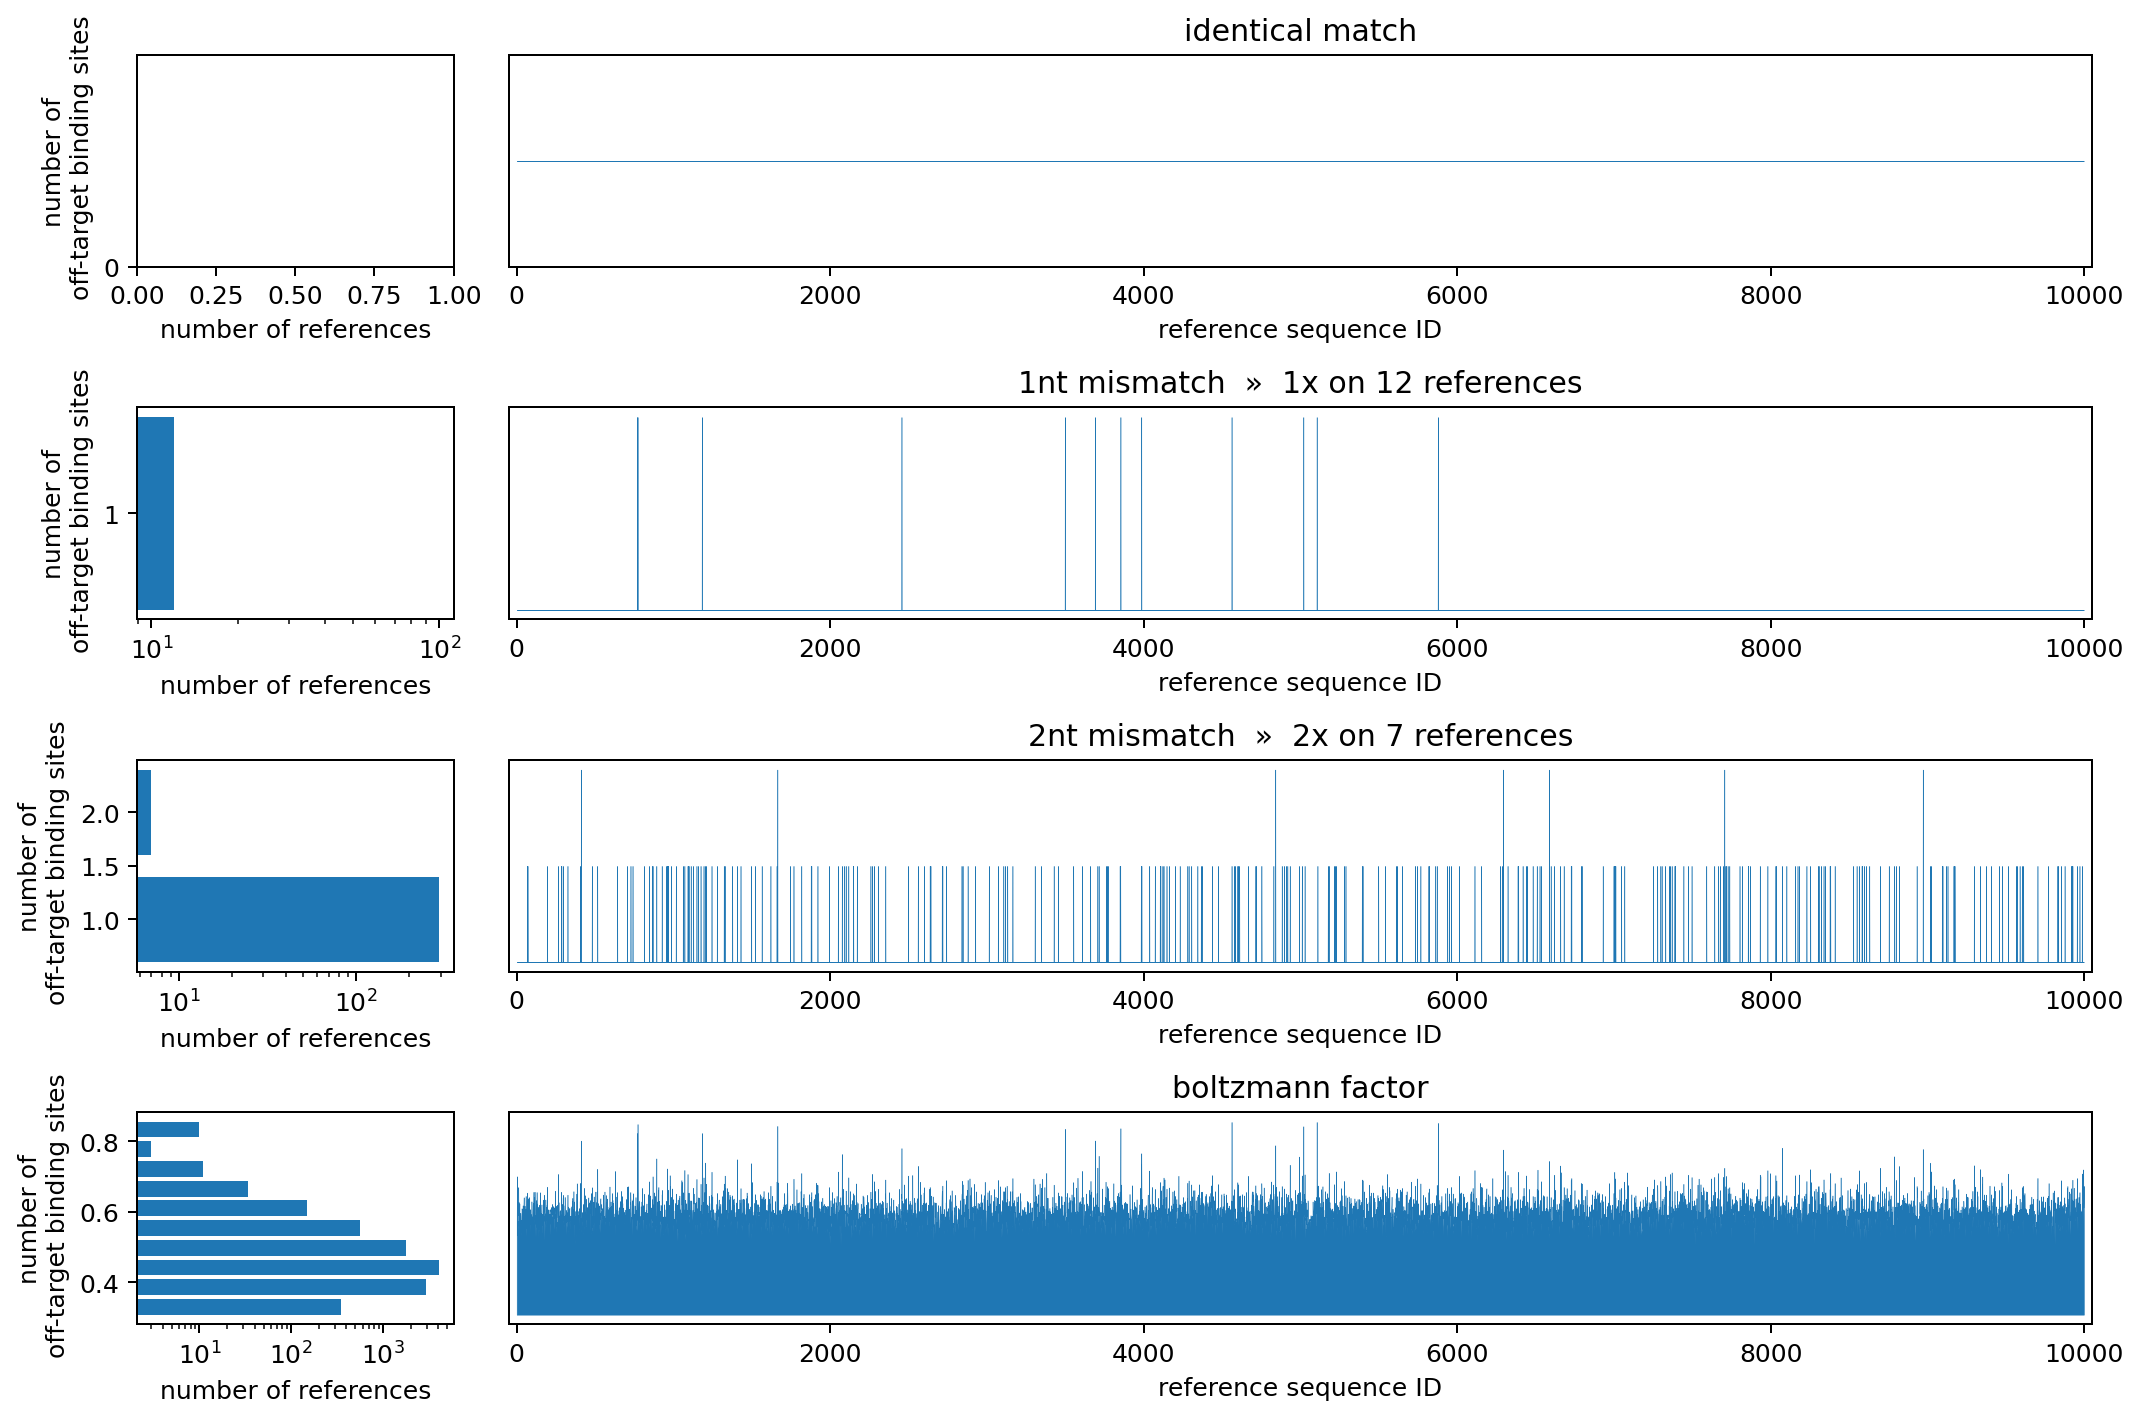


----------------------------------------------------------------------------------------------------
SEQUENCE                            ACTATCGGAGGC
SEQ_NAME                     random_target_11:23
identical match_max                            0
identical match_sum                            0
identical match_score100                     2.0
1nt mismatch_max                               1
1nt mismatch_sum                              13
1nt mismatch_score100                   2.025391
2nt mismatch_max                               2
2nt mismatch_sum                             361
2nt mismatch_score100                   2.529297
boltzmann factor_max                    0.870605
boltzmann factor_sum                      4424.0
boltzmann factor_score100               2.449219
rank_max                                  0.6875
rank_sum                                1.854167
Name: 10, dtype: object
Warning, deprecated input type for query


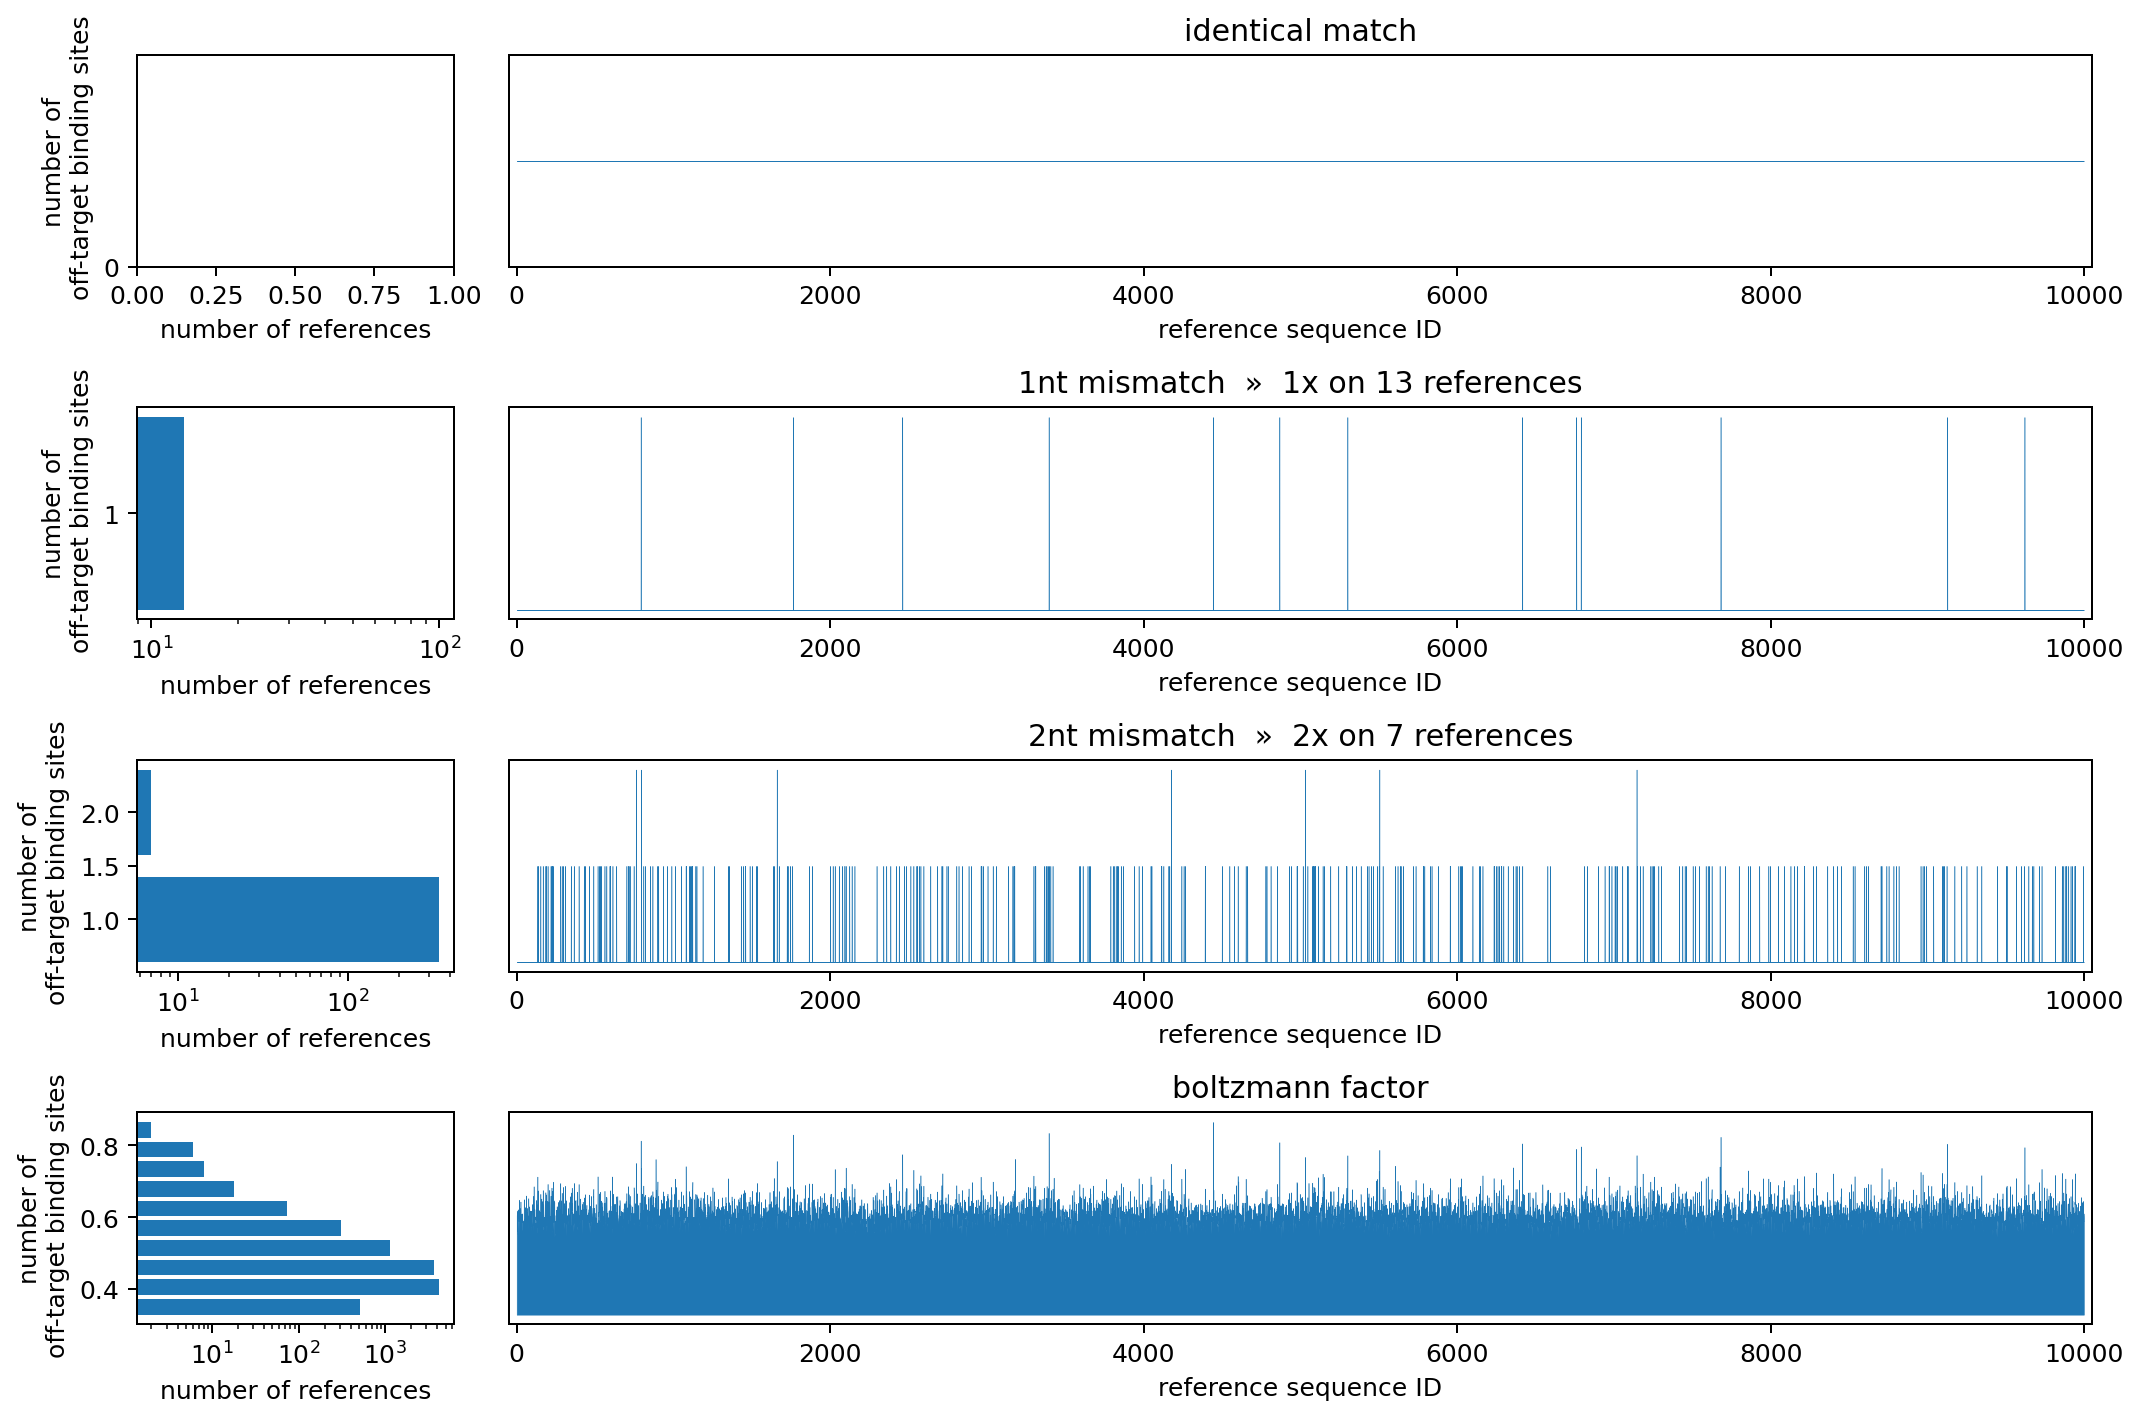


----------------------------------------------------------------------------------------------------
SEQUENCE                            GCTCGTTTCGAC
SEQ_NAME                     random_target_45:57
identical match_max                            0
identical match_sum                            0
identical match_score100                     2.0
1nt mismatch_max                               1
1nt mismatch_sum                              15
1nt mismatch_score100                   2.029297
2nt mismatch_max                               2
2nt mismatch_sum                             340
2nt mismatch_score100                   2.542969
boltzmann factor_max                    0.880371
boltzmann factor_sum                      4408.0
boltzmann factor_score100               2.449219
rank_max                                0.760417
rank_sum                                1.864583
Name: 32, dtype: object
Warning, deprecated input type for query


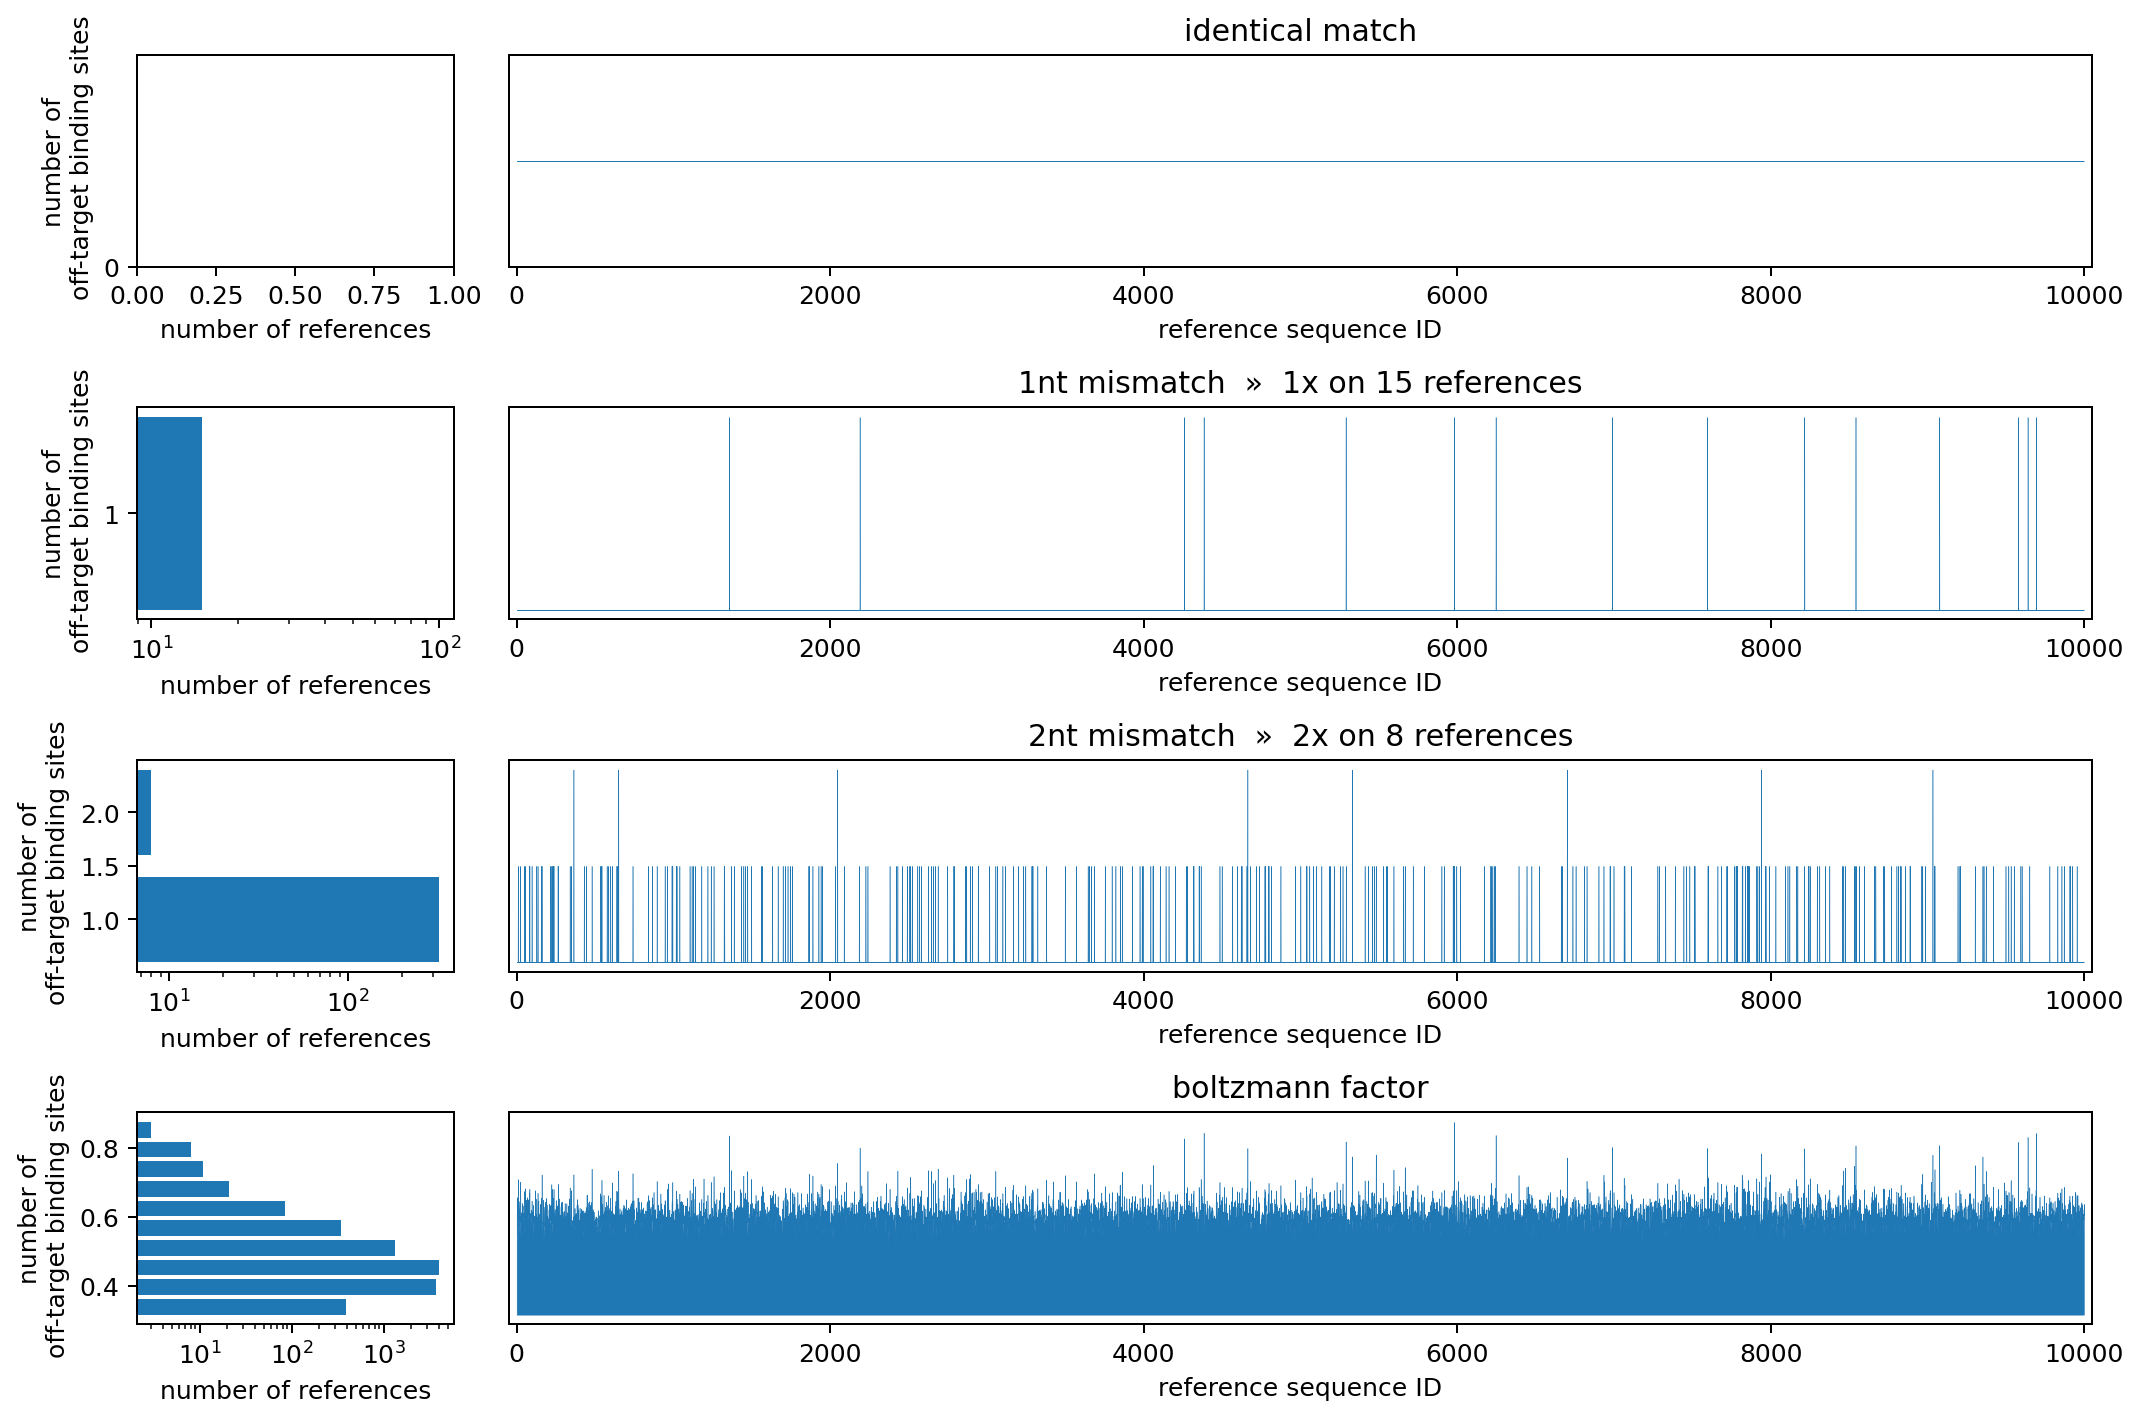


----------------------------------------------------------------------------------------------------
SEQUENCE                            CAGAAACCTACT
SEQ_NAME                     random_target_58:70
identical match_max                            0
identical match_sum                            0
identical match_score100                     2.0
1nt mismatch_max                               1
1nt mismatch_sum                              20
1nt mismatch_score100                   2.039062
2nt mismatch_max                               2
2nt mismatch_sum                             326
2nt mismatch_score100                   2.357422
boltzmann factor_max                    0.899414
boltzmann factor_sum                      4424.0
boltzmann factor_score100               2.451172
rank_max                                0.510417
rank_sum                                2.260417
Name: 42, dtype: object
Warning, deprecated input type for query


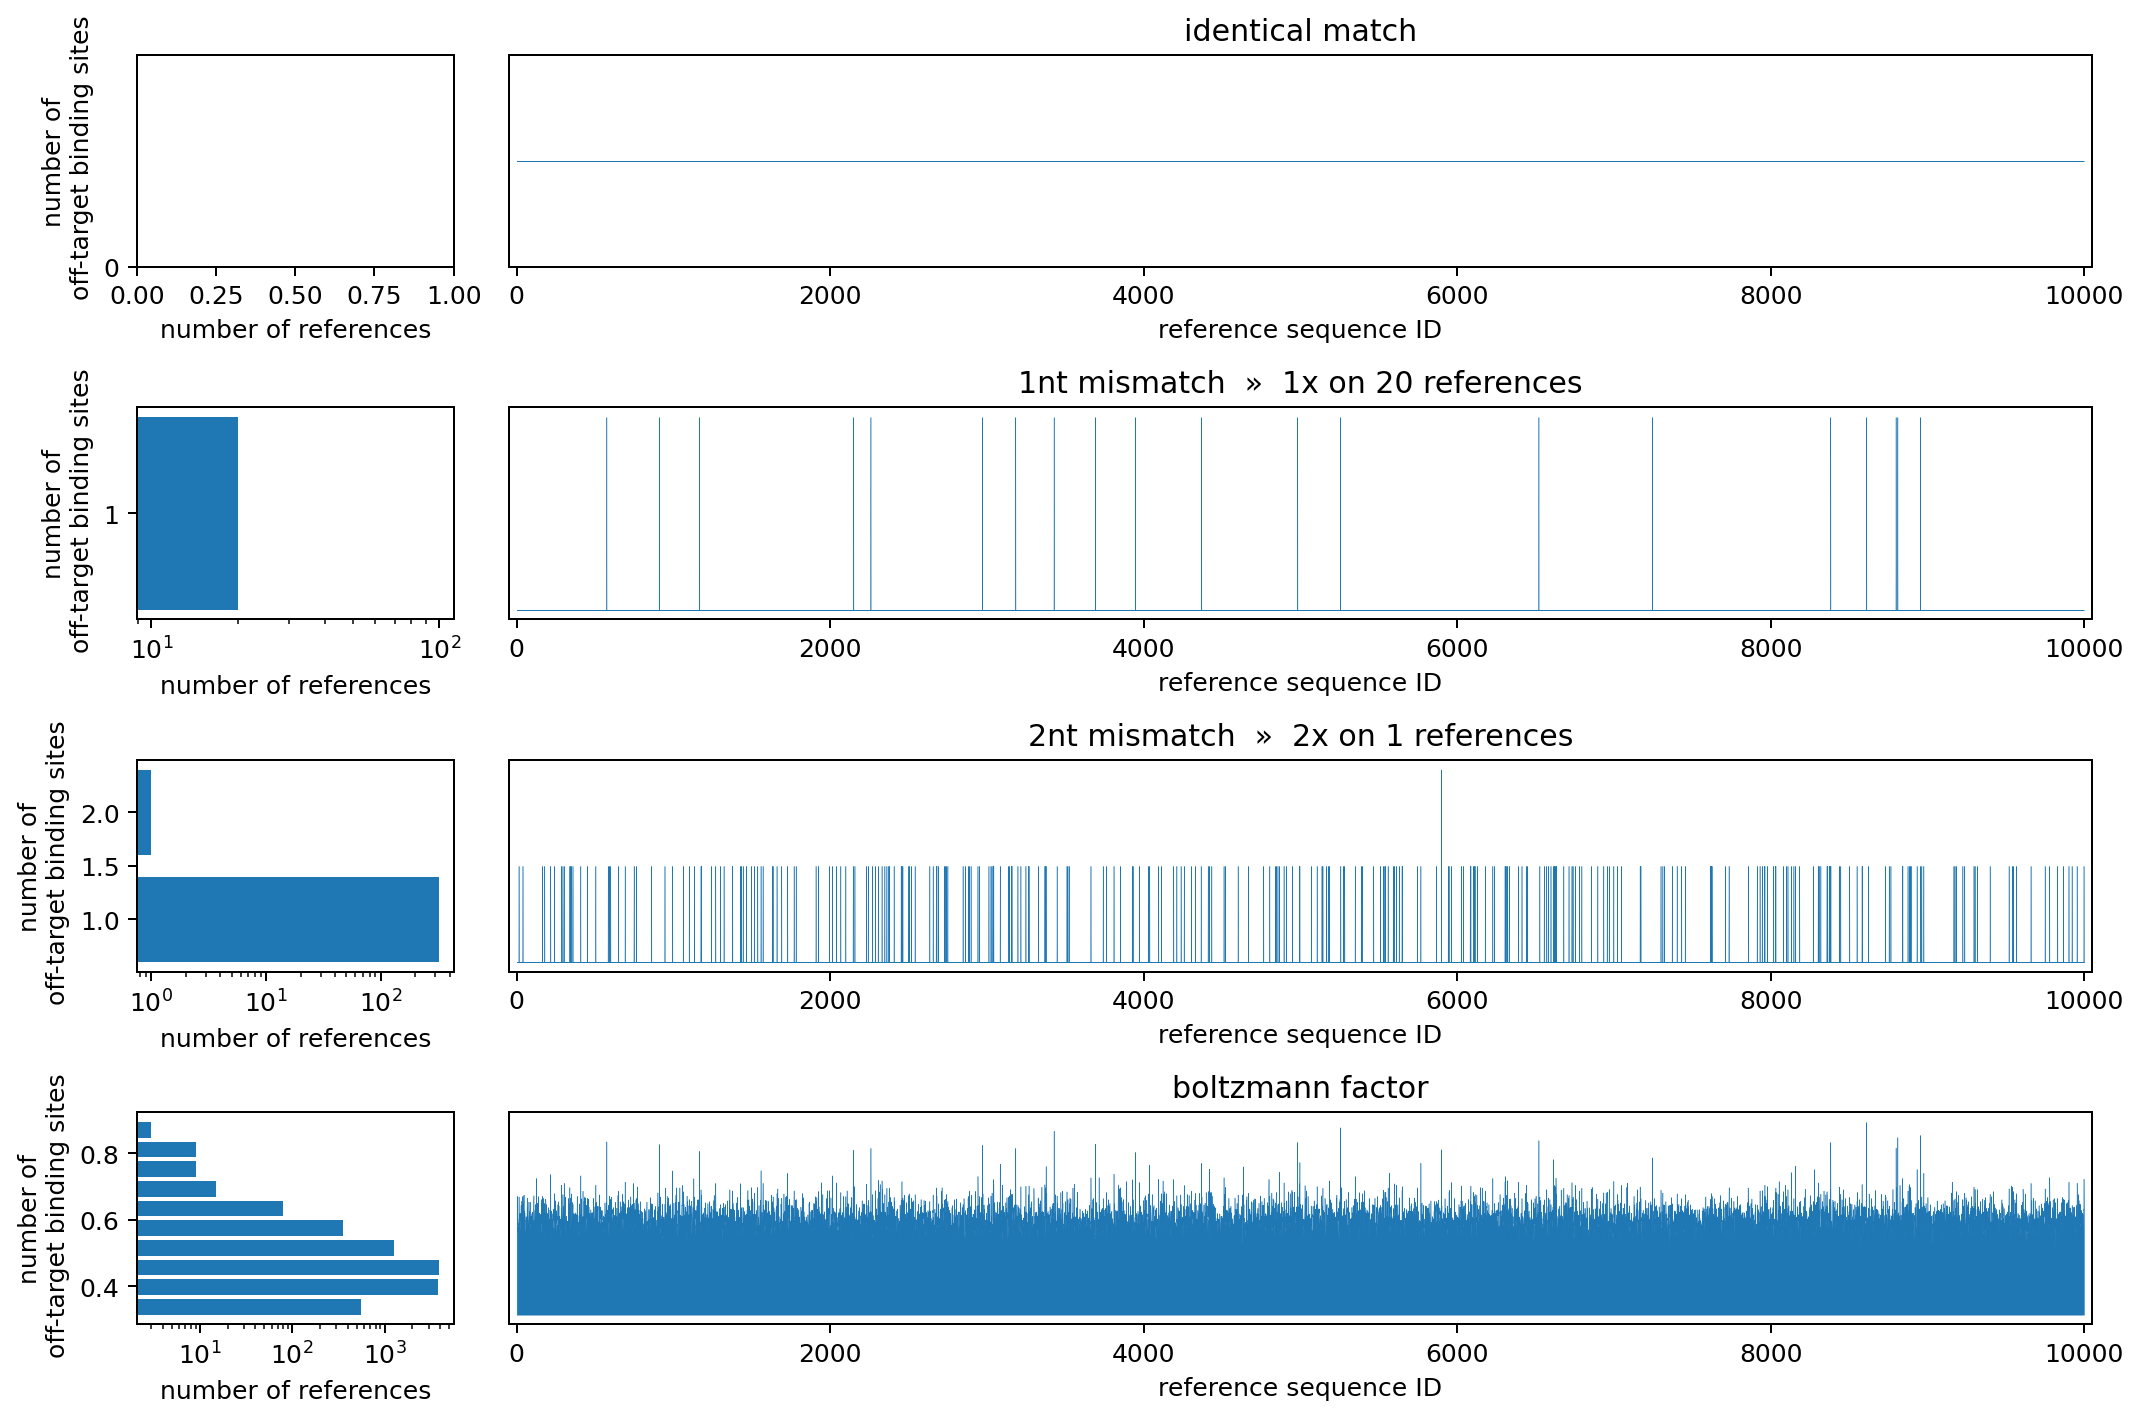


----------------------------------------------------------------------------------------------------
SEQUENCE                            GAAACCTACTTT
SEQ_NAME                     random_target_60:72
identical match_max                            0
identical match_sum                            0
identical match_score100                     2.0
1nt mismatch_max                               1
1nt mismatch_sum                              15
1nt mismatch_score100                   2.029297
2nt mismatch_max                               2
2nt mismatch_sum                             295
2nt mismatch_score100                   2.417969
boltzmann factor_max                    0.900391
boltzmann factor_sum                      4420.0
boltzmann factor_score100               2.449219
rank_max                                0.510417
rank_sum                                     1.5
Name: 43, dtype: object
Warning, deprecated input type for query


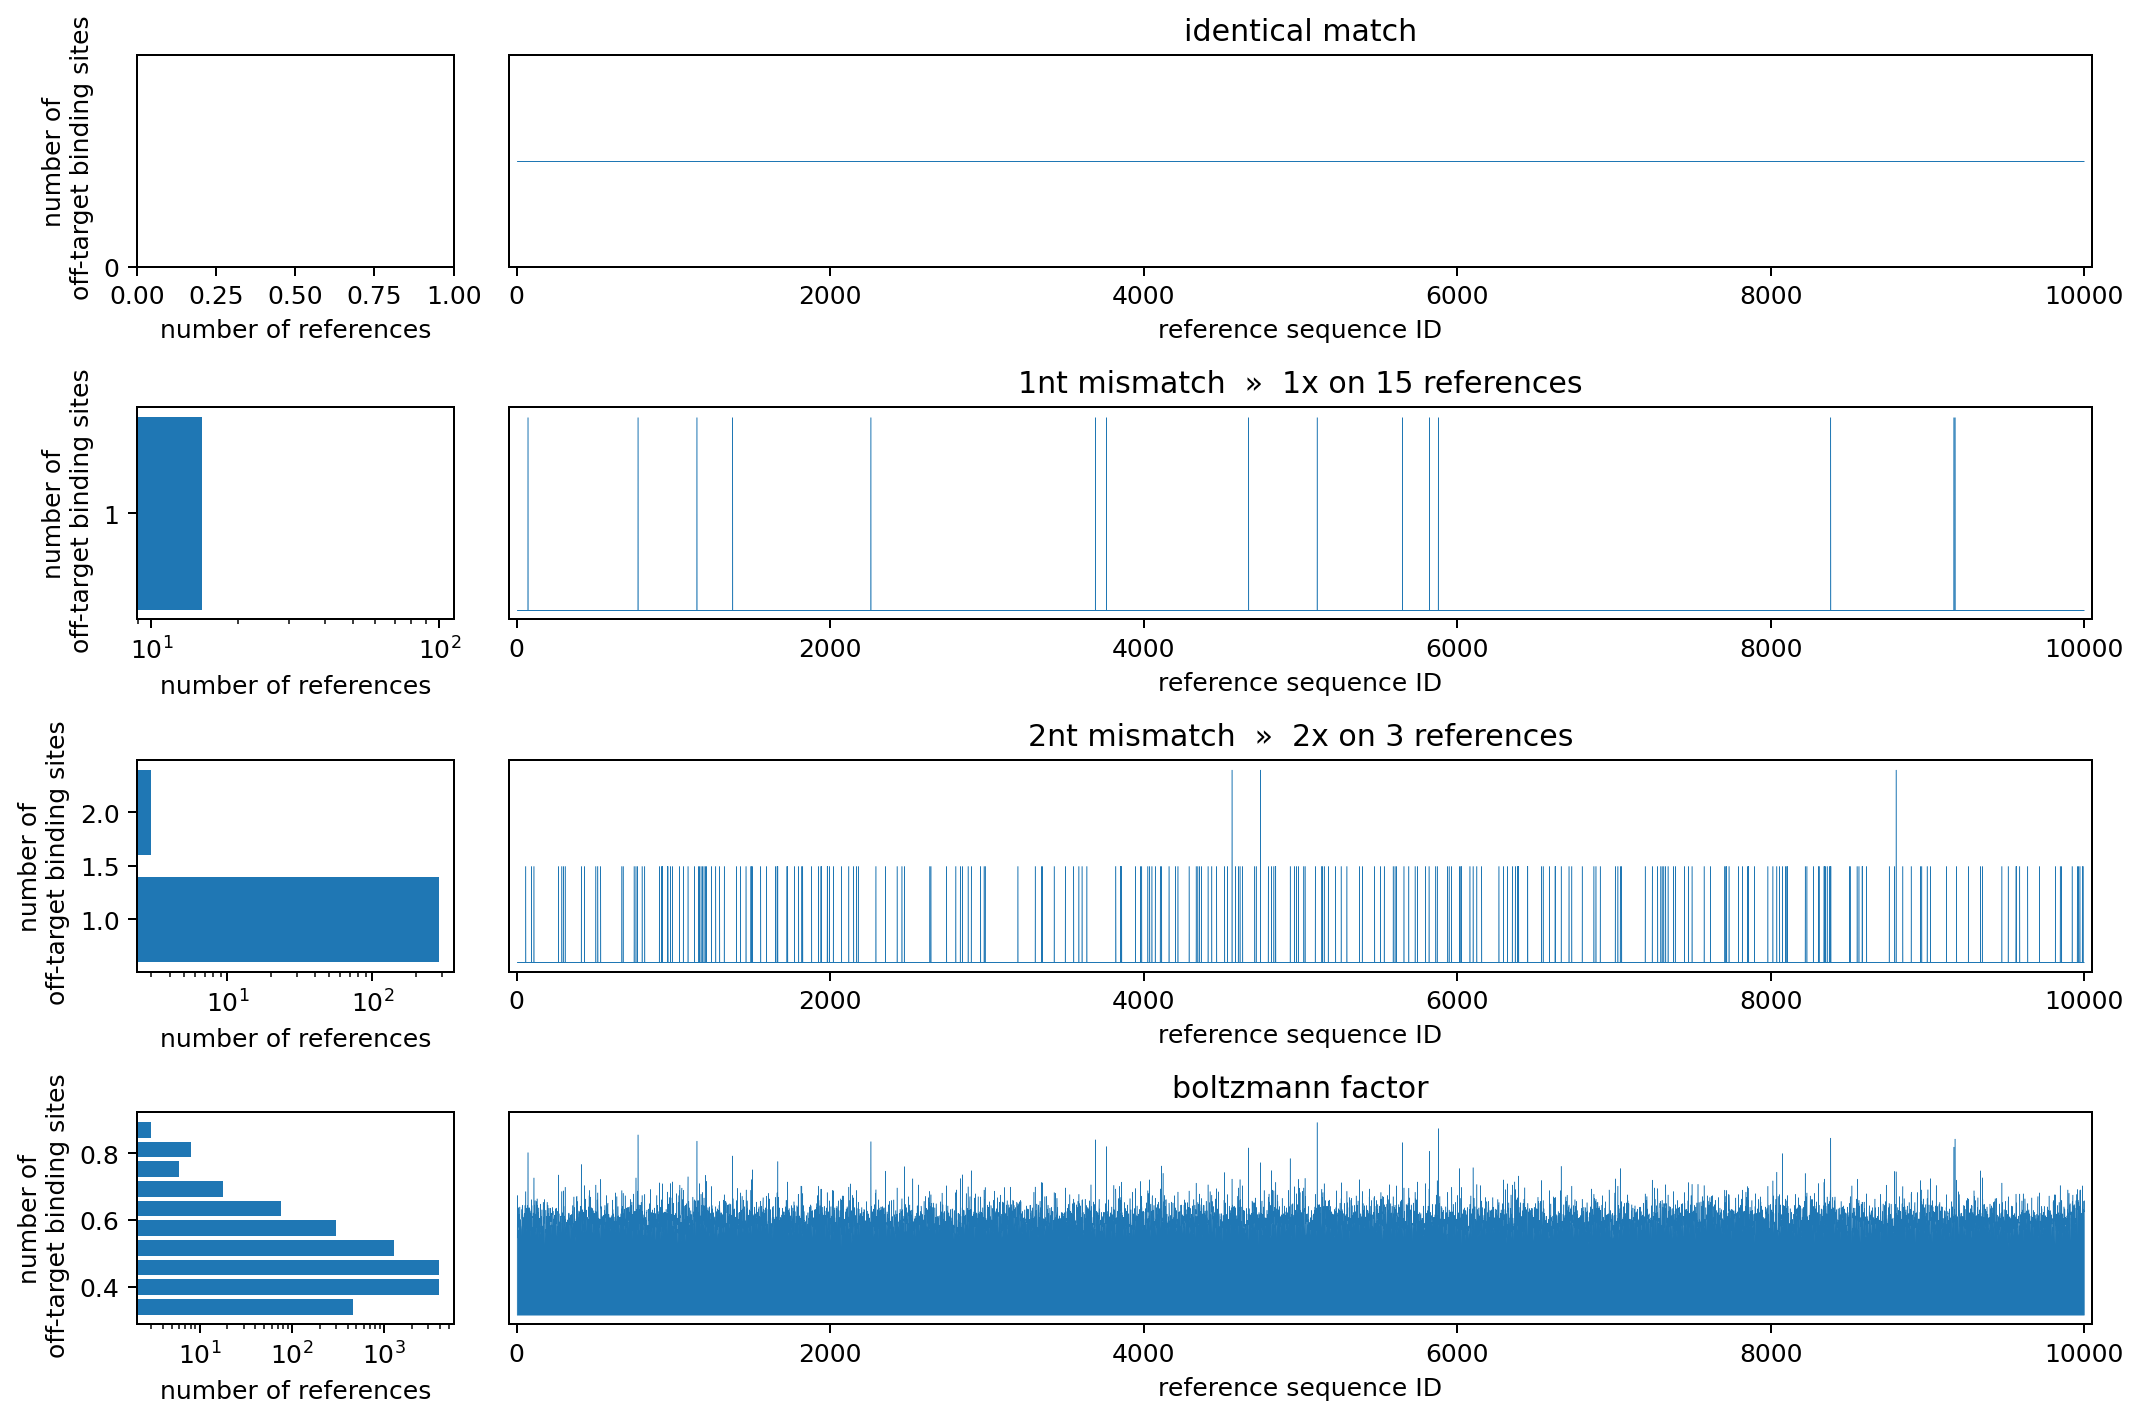

In [ ]:
## Rank remaining sequences based on obtained metrics

select["rank_max"] = 0
select["rank_sum"] = 0
for col in ['identical match_score100', '1nt mismatch_score100', '2nt mismatch_score100', 'boltzmann factor_score100', 'boltzmann factor_max', 'boltzmann factor_sum']:
    select["rank_max"] = np.max([select[col].rank(pct = True), select["rank_max"]], axis = 0)
    select["rank_sum"] += select[col].rank(pct = True)
candidates = pd.concat([select.sort_values("rank_max")[:5], select.sort_values("rank_sum")[:5]]).sort_values("boltzmann factor_max")
candidates = candidates[~candidates.index.duplicated(keep='first')]

_df = candidates.drop(["SEQUENCE","SEQ_NAME"], axis = 1) # only use numerical columns
mat = np.array(_df.values)
mat -= mat.mean(axis = 0)
mat /= (mat.std(axis = 0)+1e-9)
mat += 2*(mat.std(axis = 0)+1e-9)

fig = plt.figure(figsize = (8, 12))
plt.matshow(mat.T, fignum = 0)

for (i, j), z in np.ndenumerate(np.array(_df.values)):
    plt.text(i,j, '{:0.4g}'.format(z), ha='center', va='center', rotation = 20, fontsize = 10)

plt.yticks(np.arange(0, mat.shape[1]), labels = _df.columns);
plt.xticks(np.arange(0, mat.shape[0]), labels = _df.index);
plt.show()

for i, row in candidates.iterrows():
    print("\n" + "-"*100)
    print(row)
    query_eval(row.SEQUENCE, reference_dataset, plot = True)
    plt.show()